# Purpose
To find indicators of fighter styles so that we can indicate what a fighter's strengths are. We will examine the distributions of the various metrics used in the current data set to see if there is any connection between any of the metrics and any particular fighting style. These styles include Wrestling, Brazilian Jiu Jitsu/Submission Grappling, Striking, and possibly Boxing, and Muay Thai.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import local
from src import functions
    
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling
import pandas as pd
from sqlalchemy import create_engine

# Math
import scipy

#### Load the data

In [3]:
# Set up tables
# Credentials
USER = local.user 
PASS = local.password
HOST = local.host
PORT = local.port

#create engine
engine = create_engine(f'postgresql://{USER}:{PASS}@{HOST}:{PORT}/match_finder')

### Striking
#### Objectives
1. Create Striking Score
2. Create Wrestling Score
3. Plot these Scores

### Create Striking Score
My Striking Score will be calculated based on the differentials for a fighter Standing Significant Strikes per 15 Minutes and Knockdowns per 15 Minutes. I will convert these into z-scores and then average them together.

In [6]:
query = """
SELECT
    striking_adv.bout_id, striking_adv.fighter_id, fighters.name, events.date,
    g_ss_s_p15m_di, td_s_p15m_di, ps_p15m_di, rev_p15m_di, sba_p15m_di,
    (d_ss_s_p15m_di + c_ss_s_p15m_di) as s_ss_s_p15m_di, kd_p15m_di
FROM striking_adv
JOIN grappling_adv ON 
    CONCAT(striking_adv.bout_id, striking_adv.fighter_id, CAST(striking_adv.round AS CHAR)) =
    CONCAT(grappling_adv.bout_id, grappling_adv.fighter_id, CAST(grappling_adv.round AS CHAR))
JOIN striking_position_adv ON 
    CONCAT(striking_adv.bout_id, striking_adv.fighter_id, CAST(striking_adv.round AS CHAR)) =
    CONCAT(striking_position_adv.bout_id, striking_position_adv.fighter_id, CAST(striking_position_adv.round AS CHAR))
JOIN bouts ON bouts.id = striking_adv.bout_id
JOIN events ON events.id = bouts.event_id
JOIN fighters ON fighters.id = striking_adv.fighter_id
"""

stats = pd.read_sql(query, engine)

In [7]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25736 entries, 0 to 25735
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bout_id         25736 non-null  object 
 1   fighter_id      25736 non-null  object 
 2   name            25736 non-null  object 
 3   date            25736 non-null  object 
 4   g_ss_s_p15m_di  25736 non-null  float64
 5   td_s_p15m_di    25736 non-null  float64
 6   ps_p15m_di      25736 non-null  float64
 7   rev_p15m_di     25736 non-null  float64
 8   sba_p15m_di     25736 non-null  float64
 9   s_ss_s_p15m_di  25736 non-null  float64
 10  kd_p15m_di      25736 non-null  float64
dtypes: float64(7), object(4)
memory usage: 2.2+ MB


##### Remove fighters with no fighter page

In [8]:
stats = stats[stats['fighter_id']!='no_link']

##### Convert date to datetime

In [9]:
stats['date'] = pd.to_datetime(stats['date'])

##### Group by fighter_id

In [10]:
stats_groupby = stats.groupby('fighter_id')

In [11]:
names = stats_groupby.name.max()

In [12]:
number_of_fights = stats_groupby.bout_id.unique().map(lambda x: len(x))

In [13]:
stats_by_fighter = stats_groupby.mean()

In [27]:
stats_by_fighter['bouts'] = number_of_fights
stats_by_fighter['name'] = names

In [28]:
stats_by_fighter

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name
fighter_id,,,,,,,,,
002ca196477ce572,-12.000000,-2.500000,-5.000000,0.000000,-0.500000,-20.500000,0.000000,2,Gabriel Silva
003d82fa384ca1d0,-148.235294,0.000000,-10.588235,0.000000,0.000000,-42.352941,0.000000,1,Aalon Cruz
0052de90691d4a93,1.664626,2.777748,3.437849,0.000000,1.718925,-13.386745,-0.176471,7,Davi Ramos
008dc37cca279def,-18.616109,-2.763982,-1.442553,-1.707447,7.407751,-6.328875,0.000000,3,Sean McCorkle
009341ed974bad72,0.000000,0.000000,0.000000,0.000000,0.000000,26.418367,9.183673,1,Jiri Prochazka
...,...,...,...,...,...,...,...,...,...
ff4c3ab594c7fac3,-5.419863,-0.818182,-1.090909,0.000000,0.000000,-5.289017,-0.272727,4,Cristiano Marcello
ff6a1f63c254127e,-0.993536,-1.622809,-3.224619,0.176471,-0.563986,10.238246,2.431847,8,Albert Tumenov
ffc088e64fab57e9,-3.449876,-1.234927,-1.311850,-0.076923,-0.927235,-1.851784,0.727496,13,Quinton Jackson


##### Remove fighters with less than 3 fights

In [38]:
exp_fighters = stats_by_fighter[stats_by_fighter['bouts']>=3]
exp_fighters

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name
fighter_id,,,,,,,,,
0052de90691d4a93,1.664626,2.777748,3.437849,0.000000,1.718925,-13.386745,-0.176471,7,Davi Ramos
008dc37cca279def,-18.616109,-2.763982,-1.442553,-1.707447,7.407751,-6.328875,0.000000,3,Sean McCorkle
00a3ff40c4b2cf21,-2.634033,0.333333,-1.000000,0.000000,0.349650,-14.130536,0.000000,3,Glaico Franca Moreira
00debc804e2b1cd4,0.224194,0.975539,-1.773361,-0.340136,-1.006803,1.428231,1.161716,5,Dylan Andrews
00e11b5c8b7bfeeb,22.089162,0.282156,2.518246,0.000000,2.200644,2.034522,-0.522573,10,Luke Rockhold
...,...,...,...,...,...,...,...,...,...
fef3d17e27e916e7,2.794014,0.000000,1.125000,0.000000,0.000000,-7.814687,0.979668,4,Antonio Carvalho
ff4c3ab594c7fac3,-5.419863,-0.818182,-1.090909,0.000000,0.000000,-5.289017,-0.272727,4,Cristiano Marcello
ff6a1f63c254127e,-0.993536,-1.622809,-3.224619,0.176471,-0.563986,10.238246,2.431847,8,Albert Tumenov


##### Calculate z score

In [39]:
z_scores_striking = exp_fighters[['s_ss_s_p15m_di', 'kd_p15m_di']].apply(scipy.stats.zscore)
z_scores_striking.columns = ['z_s_ss_s_p15m_di', 'z_kd_p15m_di']
z_scores_striking

,z_s_ss_s_p15m_di,z_kd_p15m_di
fighter_id,,
0052de90691d4a93,-0.667325,-0.014288
008dc37cca279def,-0.274515,0.048405
00a3ff40c4b2cf21,-0.708722,0.048405
00debc804e2b1cd4,0.157211,0.461115
00e11b5c8b7bfeeb,0.190955,-0.137244
...,...,...
fef3d17e27e916e7,-0.357209,0.396441
ff4c3ab594c7fac3,-0.216641,-0.048484
ff6a1f63c254127e,0.647538,0.912340


##### Average z-score columns for Striking Score

In [40]:
exp_fighters['striking_score'] = (z_scores_striking['z_kd_p15m_di'] + z_scores_striking['z_s_ss_s_p15m_di'])/2

<ipython-input-40-7d8abfc02816>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_fighters['striking_score'] = (z_scores_striking['z_kd_p15m_di'] + z_scores_striking['z_s_ss_s_p15m_di'])/2


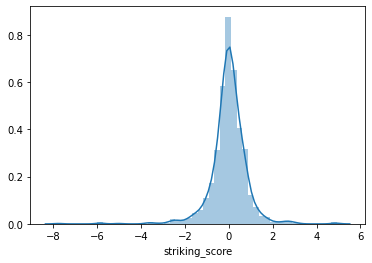

In [41]:
sns.distplot(exp_fighters['striking_score'])

In [42]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,striking_score
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759,7.145442e-18
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177,8.308359e-01
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000,-7.752954e+00
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000,-3.018800e-01
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000,1.668396e-02
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000,3.703492e-01
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000,4.914362e+00


##### Examine top fighters

In [43]:
exp_fighters.sort_values('striking_score', ascending=False).head(20)

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score
fighter_id,,,,,,,,,,
9ccdd2ce45903f34,58.026229,-2.483309,-7.785033,0.000000,1.474138,25.759171,23.275862,3,Mark Weir,4.914362
bda04c573563cc2e,54.417298,-0.444295,0.000000,0.000000,0.000000,52.387740,18.583838,6,Todd Duffee,4.821936
f14cf73e51b29254,4.527507,-1.149425,0.000000,0.000000,0.000000,67.154036,6.835531,3,Sergei Pavlovich,3.146005
c21f26bbde777573,25.539759,-2.298088,-0.857143,0.000000,0.000000,27.079519,12.229385,5,Johnny Walker,2.988926
4123fd4dcc1fe937,36.746615,3.777563,0.504836,0.000000,4.282398,20.559961,12.500000,3,David Terrell,2.855570
2cd428e9606856fd,17.766667,-1.200000,-2.100000,0.300000,0.000000,31.143989,10.574169,5,Jairzinho Rozenstruik,2.808016
a7f4d0902bb64092,6.790275,-5.276480,-4.878582,0.503356,-0.172548,-3.574527,15.893056,10,James Irvin,2.786666
365fee2da473b177,15.985893,1.302722,0.304905,-0.056511,-0.850240,38.726076,8.697515,19,Anthony Johnson,2.685660
4144798612ef96e5,25.768887,5.583333,5.666667,0.000000,2.083333,53.907358,5.988185,4,Edmen Shahbazyan,2.626865


In [44]:
exp_fighters[exp_fighters['name']=='Anderson Silva']

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score
fighter_id,,,,,,,,,,
1f454354805b6f75,3.559652,-0.828309,-0.820555,0.0,0.198123,15.721112,2.000995,24,Anderson Silva,0.855983


### Notes:
The striking score does capture some top performing strikers in the UFC with Conor McGregor and Jairzinho Rozenstruik in the top 20 of all time. One thing to note is that if you're using fights from a fighter who fought past their prime, you may not be able to make accurate comparisons. For instance, Anderson Silva, considered the best Middleweight striker of all time, is scored at .86, likely because he has not been as dominant in his most recent performances. This needs to be examined further by calculating the striking scores for fighters in their prime.

### Grappling Score

In [45]:
z_scores_grappling = exp_fighters[['g_ss_s_p15m_di', 'td_s_p15m_di', 'ps_p15m_di', 'rev_p15m_di', 'sba_p15m_di']].apply(scipy.stats.zscore)
z_scores_grappling.columns = ['z_g_ss_s_p15m_di', 'z_td_s_p15m_di', 'z_ps_p15m_di', 'z_rev_p15m_di', 'z_sba_p15m_di']
z_scores_grappling

,z_g_ss_s_p15m_di,z_td_s_p15m_di,z_ps_p15m_di,z_rev_p15m_di,z_sba_p15m_di
fighter_id,,,,,
0052de90691d4a93,0.195863,1.441830,1.443169,0.004370,1.097140
008dc37cca279def,-1.071267,-1.309085,-0.486965,-4.302653,4.678550
00a3ff40c4b2cf21,-0.072715,0.228422,-0.311942,0.004370,0.235112
00debc804e2b1cd4,0.105865,0.547213,-0.617795,-0.853621,-0.618845
00e11b5c8b7bfeeb,1.471977,0.203018,1.079478,0.004370,1.400408
...,...,...,...,...,...
fef3d17e27e916e7,0.266426,0.062955,0.528468,0.004370,0.014989
ff4c3ab594c7fac3,-0.246773,-0.343190,-0.347895,0.004370,0.014989
ff6a1f63c254127e,0.029782,-0.742607,-1.191749,0.449516,-0.340069


##### Combine z-score columns for Striking Score

In [48]:
exp_fighters['grappling_score'] = (z_scores_grappling['z_td_s_p15m_di'] + 
                                  z_scores_grappling['z_g_ss_s_p15m_di'] +
                                  z_scores_grappling['z_ps_p15m_di'] + 
                                  z_scores_grappling['z_rev_p15m_di']+
                                  z_scores_grappling['z_sba_p15m_di']) / 5

<ipython-input-48-ecb464be0da1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_fighters['grappling_score'] = (z_scores_grappling['z_td_s_p15m_di'] +


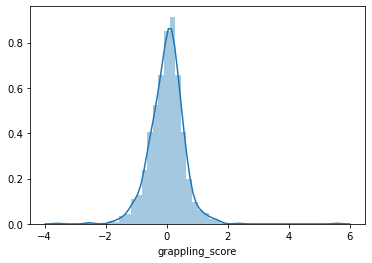

In [49]:
sns.distplot(exp_fighters['grappling_score'])

In [50]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,striking_score,grappling_score
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03,1243.000000
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759,7.145442e-18,0.000000
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177,8.308359e-01,0.563880
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000,-7.752954e+00,-3.568457
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000,-3.018800e-01,-0.313237
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000,1.668396e-02,0.039952
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000,3.703492e-01,0.317200
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000,4.914362e+00,5.590907


##### Examine top fighters

In [51]:
exp_fighters.sort_values('grappling_score', ascending=False).head(20)

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score,grappling_score
fighter_id,,,,,,,,,,,
8bdac25ce0bb874d,47.085821,6.487653,6.498034,5.571429,7.800269,-0.498036,2.259338,8,Ronda Rousey,0.450529,5.590907
84ff027394f7e470,38.929718,6.251899,13.220946,0.000000,1.127397,-10.511194,3.372327,7,Gregor Gillespie,0.369584,2.346386
b08012bbe542592a,45.113465,6.788785,10.066494,-0.639625,-0.140734,3.166663,0.000000,5,Tatiana Suarez,0.151185,1.745090
2dc1bc1a02961656,23.003802,1.647949,4.885261,0.375000,4.841381,-16.634537,1.906780,5,Manny Bermudez,-0.061139,1.687783
85d905f7c4f5a1af,15.323754,5.603226,8.506452,-0.600000,3.870968,-12.355425,2.713196,4,Murilo Bustamante,0.201183,1.656849
4144798612ef96e5,25.768887,5.583333,5.666667,0.000000,2.083333,53.907358,5.988185,4,Edmen Shahbazyan,2.626865,1.638394
2f181c0467965b98,11.926590,-1.188073,2.921443,2.188073,1.688073,-6.064220,0.500000,3,Brendan Allen,-0.016876,1.630129
8f4eeaf7a0df7c1a,22.295775,1.500000,9.250000,-1.000000,6.750000,-27.176056,0.545775,4,Teemu Packalen,-0.596241,1.556115
032cc3922d871c7f,35.622589,5.143912,5.429699,0.000000,0.747487,3.289607,0.300725,12,Khabib Nurmagomedov,0.208024,1.530958


In [54]:
exp_fighters[exp_fighters['name']=='Demian Maia']

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name,striking_score,grappling_score
fighter_id,,,,,,,,,,,
427b5953ac8e3a27,4.825457,2.429307,3.722007,-0.023621,1.045441,-9.530934,-0.636062,32,Demian Maia,-0.315145,0.767139


In [56]:
len(exp_fighters[exp_fighters['grappling_score']<.767139])/len(exp_fighters)

0.9452936444086887

### The Importance of the Distribution
In order to calculate the grappling and striking scores, I use the mean and standard deviation. Because the rating is so sensitive to the distribution, I want to examine distributions of the underlying techniques over the years because it may fluctuate. My goal is to find a point in time where the distributions begin to resemble the current ones. In order to determine this, I will look at the difference in mean and standard deviation between the current stats and a subset from all fights prior to a given year.

In [61]:
stats.date.map(lambda x: x.year).describe()

count    25736.000000
mean      2013.742035
std          4.518306
min       1999.000000
25%       2011.000000
50%       2015.000000
75%       2017.000000
max       2020.000000
Name: date, dtype: float64

The oldest match is from 1999 so we'll start in 2000, giving us a year of fights to create a normal distribution.

In [65]:
stats_2000 = stats[stats['date'].map(lambda x: x.year)<2000]
stats_2000

,bout_id,fighter_id,name,date,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di
3150,1db8bed8b4d30fb3,911fb265462f0d94,Travis Fulton,1999-07-16,3.0,3.00000,6.0,0.0,0.00000,24.0000,0.0000
3151,1db8bed8b4d30fb3,911fb265462f0d94,Travis Fulton,1999-07-16,36.0,0.00000,6.0,0.0,0.00000,12.0000,3.0000
3152,1db8bed8b4d30fb3,c2a7623f398d9bd7,David Dodd,1999-07-16,-3.0,-3.00000,-6.0,0.0,0.00000,-24.0000,0.0000
3153,1db8bed8b4d30fb3,c2a7623f398d9bd7,David Dodd,1999-07-16,-36.0,0.00000,-6.0,0.0,0.00000,-12.0000,-3.0000
4422,2ab41c5519d0b1b9,6291ac0a3726732f,Pete Williams,1999-11-19,-6.0,-3.00000,3.0,0.0,0.00000,6.0000,3.0000
...,...,...,...,...,...,...,...,...,...,...,...
23946,ee1950e871aa5cc2,d56caaa5e123f518,Masutatsu Yano,1999-11-19,0.0,0.00000,0.0,0.0,0.00000,-23.4375,-4.6875
23947,ee1950e871aa5cc2,d71d968dc6ecfdaf,Katsuhisa Fujii,1999-11-19,-45.0,-3.00000,0.0,0.0,0.00000,30.0000,0.0000
23948,ee1950e871aa5cc2,d71d968dc6ecfdaf,Katsuhisa Fujii,1999-11-19,0.0,0.00000,0.0,0.0,0.00000,23.4375,4.6875
24013,eebf672428b168b7,5ca158b1cc9cb242,Jason Godsey,1999-09-24,0.0,7.03125,0.0,0.0,-7.03125,-14.0625,0.0000


In [68]:
stats_groupby_2000 = stats_2000.groupby('fighter_id')

names_2000 = stats_groupby_2000.name.max()

number_of_fights_2000 = stats_groupby_2000.bout_id.unique().map(lambda x: len(x))

stats_by_fighter_2000 = stats_groupby_2000.mean()

stats_by_fighter_2000['bouts'] = number_of_fights_2000
stats_by_fighter_2000['name'] = names_2000

stats_by_fighter_2000

##### Remove fighters with less than 3 fights

exp_fighters_2000 = stats_by_fighter_2000[stats_by_fighter_2000['bouts']>=3]
exp_fighters_2000

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name
fighter_id,,,,,,,,,


No fighters have had at least 3 fights in 1999, so we'll go to 2001 as the cutoff.

In [71]:
def fights_from(year, stats=stats):
    stats = stats[stats['date'].map(lambda x: x.year)<year]

    stats_groupby = stats.groupby('fighter_id')

    names = stats_groupby.name.max()

    number_of_fights = stats_groupby.bout_id.unique().map(lambda x: len(x))

    stats_by_fighter = stats_groupby.mean()

    stats_by_fighter['bouts'] = number_of_fights
    stats_by_fighter['name'] = names

    stats_by_fighter

    ##### Remove fighters with less than 3 fights

    exp_fighters = stats_by_fighter[stats_by_fighter['bouts']>=3]
    return exp_fighters

In [72]:
exp_fighters_2001 = fights_from(2001)

In [73]:
exp_fighters_2001

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts,name
fighter_id,,,,,,,,,
263ebd4a669e1e98,2.800000,4.421429,0.000000,0.000000,4.542857,-10.200000,0.000000,3,Fabiano Iha
2f732dd9210d301f,21.857143,5.245441,1.200000,-0.319149,1.287994,-11.156079,-0.503571,3,Tito Ortiz
33e33d51f289d2a1,-3.000000,-3.857143,-1.714286,0.000000,-1.714286,17.571429,0.000000,3,Maurice Smith
44260175069b6276,23.093944,0.698758,2.147516,0.375000,1.448758,10.448758,7.500000,4,Jens Pulver
4f74c8be51db8a37,-33.173665,-1.250000,-1.281139,0.000000,0.000000,-8.246263,0.000000,3,Daiju Takase
621a6c59f88a44fe,56.710949,13.313869,0.600000,0.000000,-9.600000,4.800000,0.000000,3,Matt Hughes
6859f67468ba8489,-0.138644,2.034053,-0.273639,0.000000,0.692308,-2.103375,-0.230769,3,Kevin Randleman
8d26912cd2aeb366,26.725717,-1.240809,5.444055,0.000000,3.446691,15.328331,0.000000,3,Jeremy Horn
9f488f520ed25bbf,-10.316479,-2.803874,-0.857143,0.000000,-1.013958,-2.254807,0.000000,3,Kenichi Yamamoto


In [83]:
exp_fighters_2001.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,7.094143,1.082155,0.569531,-0.005271,-0.298559,3.733089,0.712325,3.133333
std,20.648114,4.435141,2.229695,0.191231,3.216660,10.292364,2.077491,0.351866
min,-33.173665,-3.857143,-3.200184,-0.428571,-9.600000,-11.156079,-0.751880,3.000000
25%,-3.997907,-1.289683,-0.642857,0.000000,-1.364122,-2.627404,0.000000,3.000000
50%,2.800000,-0.666667,0.000000,0.000000,0.000000,2.449239,0.000000,3.000000
75%,19.015038,3.185177,1.673758,0.000000,1.279590,12.069482,0.000000,3.000000
max,56.710949,13.313869,5.444055,0.375000,4.542857,19.975770,7.500000,4.000000


In [81]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000


In [84]:
exp_fighters_2001.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1228.000000,-1228.000000,-1228.000000,-1228.000000,-1228.000000,-1228.000000,-1228.000000,-1228.000000
mean,8.564349,1.208979,0.780777,-0.003539,-0.274751,5.129573,0.848578,-4.859426
std,4.636418,2.419826,-0.299853,-0.205362,1.627589,-7.682503,-0.738491,-5.199311
min,111.611052,2.813406,14.171437,2.823529,5.964487,118.814932,35.248120,0.000000
25%,3.350578,0.043651,0.767495,0.108836,-0.778998,8.196367,0.621142,-1.000000
50%,3.462080,-0.429825,0.114825,0.000000,0.000000,3.995772,0.000000,-3.000000
75%,13.046243,2.092435,0.485040,-0.110925,0.752386,3.002485,-0.500230,-7.000000
max,-16.610856,4.980535,-7.776891,-5.196429,-14.954759,-47.178266,-15.775862,-31.000000


### 2002

In [85]:
exp_fighters_2002 = fights_from(2002)

In [87]:
exp_fighters_2002.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,6.678445,0.806805,0.415532,-0.068319,-0.137362,2.178587,0.523963,3.814815
std,29.798994,6.925604,2.101562,0.288463,2.477399,14.690622,6.530656,1.110684
min,-39.181818,-11.117126,-3.714795,-0.857143,-7.906404,-32.807692,-11.688312,3.000000
25%,-6.633919,-1.929170,-0.744361,-0.093867,-1.102217,-5.216454,-0.362395,3.000000
50%,2.558305,-0.522774,0.428571,0.000000,0.000000,4.643892,0.000000,3.000000
75%,12.544697,2.015810,1.403256,0.000000,0.476708,10.369112,0.614844,4.000000
max,127.104377,27.441077,5.050505,0.500000,6.340909,37.710438,29.124579,6.000000


In [88]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000


In [89]:
exp_fighters_2002.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1216.000000,-1216.000000,-1216.000000,-1216.000000,-1216.000000,-1216.000000,-1216.000000,-1216.000000
mean,8.148651,0.933629,0.626778,-0.066587,-0.113554,3.575072,0.660216,-4.177945
std,13.787297,4.910290,-0.427986,-0.108130,0.888327,-3.284244,3.714674,-4.440493
min,105.602899,-4.446576,13.656826,2.394958,7.658083,97.163319,24.311688,0.000000
25%,0.714566,-0.595837,0.665992,0.014969,-0.517093,5.607317,0.258747,-1.000000
50%,3.220385,-0.285932,0.543396,0.000000,0.000000,6.190425,0.000000,-3.000000
75%,6.575902,0.923068,0.214539,-0.110925,-0.050496,1.302114,0.114614,-6.000000
max,53.782573,19.107744,-8.170441,-5.071429,-13.156707,-29.443598,5.848717,-29.000000


### 2003

In [90]:
exp_fighters_2003 = fights_from(2003)

In [92]:
exp_fighters_2003.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1194.000000,-1194.000000,-1194.000000,-1194.000000,-1194.000000,-1194.000000,-1194.000000,-1194.000000
mean,1.998459,0.192925,0.487878,-0.026115,0.556741,2.697406,-0.123287,-3.727453
std,7.680574,1.163161,0.272011,0.007998,1.185579,-4.635181,0.726250,-4.096651
min,58.062495,1.239719,11.304206,2.161192,12.105435,97.163319,24.888889,0.000000
25%,-1.222944,-0.809524,0.553210,-0.105450,-0.534691,3.357104,-0.172509,-1.000000
50%,-0.462920,-0.693765,0.114825,0.000000,0.000000,3.702558,0.000000,-2.000000
75%,9.614775,1.007258,0.161282,-0.100616,0.836432,0.337165,-0.440538,-5.000000
max,-4.940555,0.315344,-4.714494,-4.671429,-5.087765,-26.166007,-15.534913,-27.000000


### 2004

In [93]:
exp_fighters_2004 = fights_from(2004)

In [94]:
exp_fighters_2004.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1188.000000,-1188.000000,-1188.000000,-1188.000000,-1188.000000,-1188.000000,-1188.000000,-1188.000000
mean,2.362033,-0.053607,0.119634,-0.011825,0.342553,3.400462,0.249633,-3.210941
std,6.260397,0.579497,0.366836,-0.048534,2.295767,7.351469,1.613172,-3.591482
min,58.062495,2.193722,9.586589,2.252101,0.000000,42.086854,24.888889,0.000000
25%,-0.536851,-1.008903,0.300433,0.108836,-0.430188,4.603341,-0.330935,-1.000000
50%,1.084834,-0.493579,0.114825,0.000000,0.000000,2.963492,0.000000,-2.000000
75%,5.692172,0.755855,-0.145652,-0.105771,0.695333,0.674935,0.285969,-4.000000
max,-4.940555,-1.770659,-4.714494,-4.671429,1.088668,72.250921,0.000000,-24.000000


### 2005

In [95]:
exp_fighters_2005 = fights_from(2005)

In [96]:
exp_fighters_2005.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1173.000000,-1173.000000,-1173.000000,-1173.000000,-1173.000000,-1173.000000,-1173.000000,-1173.000000
mean,2.745684,0.065705,0.235638,-0.003535,0.273355,3.835278,0.290160,-3.164188
std,4.936178,0.564258,0.408276,-0.103920,1.992217,3.830992,1.116366,-3.216986
min,58.062495,1.099121,9.586589,2.304732,0.000000,29.053756,24.888889,0.000000
25%,0.102729,-0.572565,0.418439,0.108836,-0.569042,4.956709,-0.208960,-1.000000
50%,-0.676235,0.283759,0.114825,0.000000,0.000000,2.659085,0.000000,-2.000000
75%,4.351659,1.039400,-0.191853,-0.110925,0.937101,2.219819,0.489379,-4.000000
max,-4.940555,-2.541153,-4.714494,-4.919255,-3.631189,40.769930,0.000000,-23.000000


### 2006

In [99]:
exp_fighters_2006 = fights_from(2006)

In [100]:
exp_fighters_2006.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1155.000000,-1155.000000,-1155.000000,-1155.000000,-1155.000000,-1155.000000,-1155.000000,-1155.000000
mean,3.183736,0.290769,0.505676,-0.009841,0.309833,2.425020,0.209370,-2.958669
std,4.493044,0.657397,0.753042,-0.060629,1.790662,2.695375,1.276234,-2.980570
min,58.062495,1.521964,9.586589,2.098255,0.000000,29.053756,18.651869,0.000000
25%,0.546065,-0.407756,0.334151,0.102788,-0.448715,4.409252,-0.070559,-1.000000
50%,0.409473,0.236842,0.114825,0.000000,0.071888,0.851426,0.000000,-2.000000
75%,4.441582,1.017972,0.425497,-0.075120,0.845723,1.038478,0.379737,-4.000000
max,-4.940555,-1.617819,-2.566140,-4.821429,-3.631189,9.467910,0.000000,-21.000000


### 2007

In [101]:
exp_fighters_2007 = fights_from(2007)

In [102]:
exp_fighters_2007.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-1118.000000,-1118.000000,-1118.000000,-1118.000000,-1118.000000,-1118.000000,-1118.000000,-1118.000000
mean,2.398876,0.073018,0.292231,0.022544,0.201704,2.923967,0.256824,-2.592759
std,2.523099,0.683380,0.571242,-0.024004,1.196672,1.301506,1.707770,-2.685924
min,58.062495,0.317325,9.586589,2.161192,0.000000,29.053756,16.050000,0.000000
25%,0.751976,-0.586383,0.129214,0.108836,-0.565056,3.720650,-0.036778,-1.000000
50%,1.858488,0.084328,0.354808,0.000000,0.194417,2.354677,0.000000,-2.000000
75%,4.237287,1.119856,0.473942,0.096687,0.946934,1.392123,0.352042,-3.000000
max,-4.940555,-1.422962,-3.942671,-4.071429,-9.964430,-0.802070,0.000000,-18.000000


In [ ]:
v

### 2008

In [105]:
exp_fighters_2011 = fights_from(2011)

In [106]:
exp_fighters_2011.describe() - exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,-919.000000,-919.000000,-919.000000,-919.000000,-919.000000,-919.000000,-919.000000,-919.000000
mean,2.001212,0.134717,0.241001,0.009870,0.089215,0.842912,0.279628,-1.292142
std,1.070536,0.446481,0.584977,0.030535,0.439524,0.139599,0.503812,-1.635677
min,58.062495,-1.370267,6.534607,0.394958,0.000000,29.053756,19.928571,0.000000
25%,0.222258,-0.312312,-0.248818,-0.051269,-0.337953,1.744068,0.010032,-1.000000
50%,0.901379,0.182158,0.128735,0.000000,0.000000,0.297328,0.000000,0.000000
75%,3.042688,0.761504,0.716486,0.085878,0.474208,0.377160,0.218414,-1.000000
max,3.457452,-0.247772,-2.310534,-3.771429,-12.075960,7.842524,0.000000,-11.000000


In [107]:
exp_fighters.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,-1.470205,-0.126824,-0.211246,-0.001733,-0.023809,-1.396485,-0.136253,7.992759
std,16.011697,2.015315,2.529548,0.396593,1.589072,17.974866,2.815982,5.551177
min,-144.784717,-6.670549,-17.371622,-3.252101,-15.564487,-129.971011,-36.000000,3.000000
25%,-7.348485,-1.333333,-1.410352,-0.108836,-0.585124,-10.823771,-0.621142,4.000000
50%,-0.662080,-0.236842,-0.114825,0.000000,0.000000,-1.546533,0.000000,6.000000
75%,5.968795,1.092742,1.188718,0.110925,0.527204,9.066998,0.500230,10.000000
max,73.321805,8.333333,13.220946,5.571429,19.497616,67.154036,23.275862,35.000000


In [108]:
exp_fighters_2011.describe()

,g_ss_s_p15m_di,td_s_p15m_di,ps_p15m_di,rev_p15m_di,sba_p15m_di,s_ss_s_p15m_di,kd_p15m_di,bouts
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,0.531007,0.007893,0.029755,0.008137,0.065406,-0.553572,0.143375,6.700617
std,17.082233,2.461796,3.114525,0.427128,2.028595,18.114466,3.319794,3.915501
min,-86.722222,-8.040816,-10.837014,-2.857143,-15.564487,-100.917255,-16.071429,3.000000
25%,-7.126227,-1.645646,-1.659170,-0.160104,-0.923077,-9.079703,-0.611110,3.000000
50%,0.239299,-0.054684,0.013910,0.000000,0.000000,-1.249205,0.000000,6.000000
75%,9.011483,1.854247,1.905204,0.196803,1.001412,9.444158,0.718645,9.000000
max,76.779256,8.085561,10.910412,1.800000,7.421655,74.996560,23.275862,24.000000
